In [1]:
pip install --upgrade tensorflow

In [2]:
pip install tensorflow keras rembg onnxruntime

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# /content/drive/MyDrive/UBC/Visual_AI_Hackathon/dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten")

print("Path to dataset files:", path)

100%|██████████| 4.77G/4.77G [01:02<00:00, 81.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten/versions/1


----------

## Remove Background

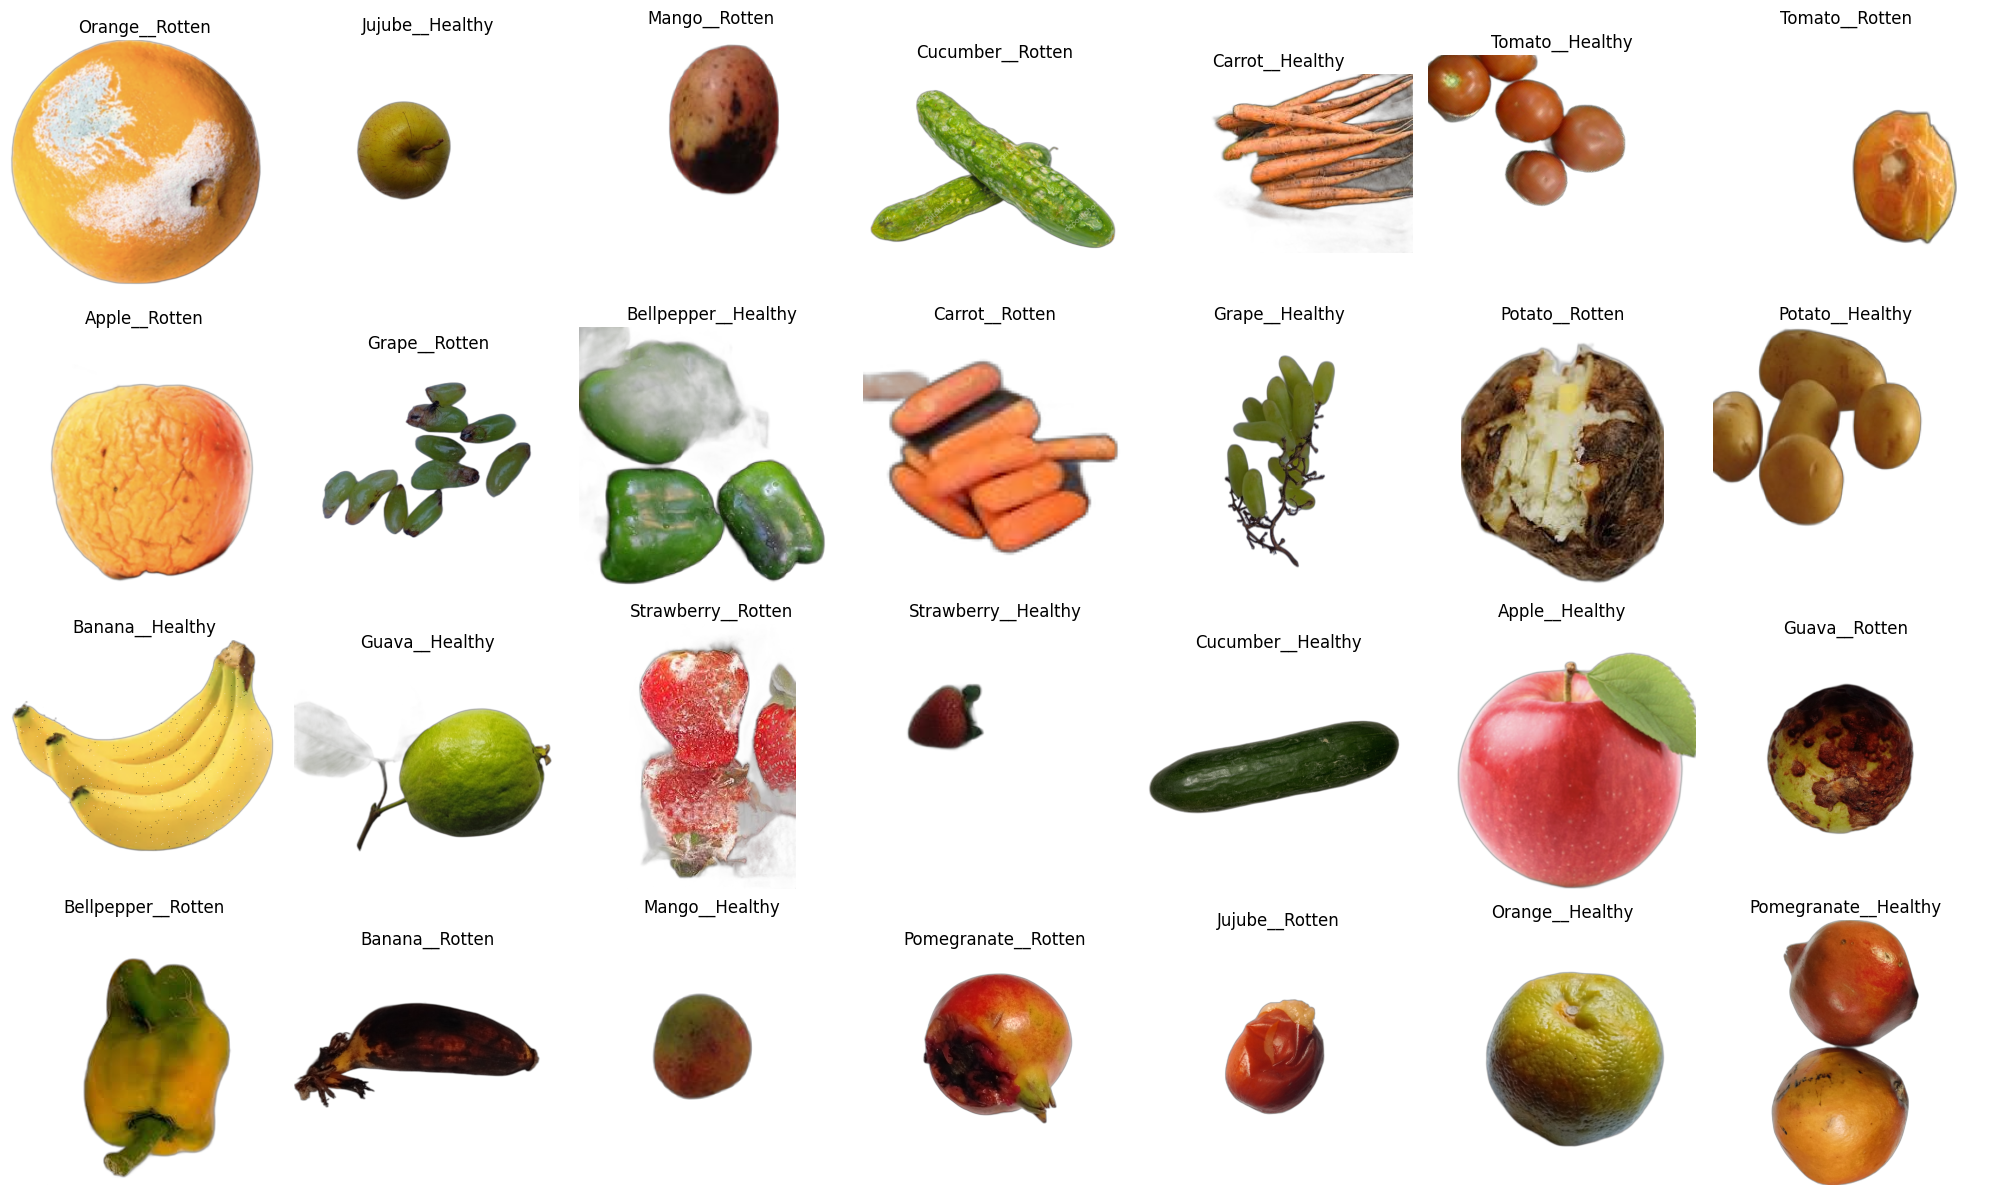

In [ ]:
import os
import shutil
import random
from rembg import remove
from PIL import Image
import matplotlib.pyplot as plt

# Define your input (original) and output (processed) directories
input_dir = "/content/drive/MyDrive/UBC/Visual_AI_Hackathon/dataset/Fruit_And_Vegetable_Diseases_Dataset"
output_dir = "/content/drive/MyDrive/UBC/Visual_AI_Hackathon/dataset/Fruit_And_Vegetable_Diseases_Dataset_BG-Removed"

# Limit on how many images to process per subfolder
MAX_IMAGES_PER_FOLDER = 1

# If the output directory exists, remove it for a fresh start (optional)
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

# Step 1: Recreate the subfolder structure in output_dir
for folder_name in os.listdir(input_dir):
    src_folder = os.path.join(input_dir, folder_name)
    if os.path.isdir(src_folder):
        # Create a matching subfolder in output_dir
        dst_folder = os.path.join(output_dir, folder_name)
        os.makedirs(dst_folder, exist_ok=True)

# Step 2: Process only a subset (1) image in each subfolder
for folder_name in os.listdir(input_dir):
    src_folder = os.path.join(input_dir, folder_name)
    if not os.path.isdir(src_folder):
        continue

    dst_folder = os.path.join(output_dir, folder_name)

    # Gather all images in this subfolder
    all_images = [
        f for f in os.listdir(src_folder)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    # If there are more images than MAX_IMAGES_PER_FOLDER, randomly sample
    if len(all_images) > MAX_IMAGES_PER_FOLDER:
        sampled_images = random.sample(all_images, MAX_IMAGES_PER_FOLDER)
    else:
        sampled_images = all_images

    # Remove background for each sampled image
    for file_name in sampled_images:
        src_path = os.path.join(src_folder, file_name)
        dst_path = os.path.join(dst_folder, file_name)

        # Open the image
        with open(src_path, "rb") as inp:
            img_bytes = inp.read()

        # Remove the background (rembg returns PNG bytes with alpha)
        out_bytes = remove(img_bytes)

        # Save the resulting image
        with open(dst_path, "wb") as out:
            out.write(out_bytes)

# Step 3: Display ALL processed images in a single figure
processed_subfolders = [
    d for d in os.listdir(output_dir)
    if os.path.isdir(os.path.join(output_dir, d))
]

# We expect up to 28 subfolders (one per fruit/vegetable + healthy/rotten)
num_subfolders = len(processed_subfolders)

# Set up a figure grid large enough to hold up to 28 subplots
# (4 rows x 7 columns = 28). Adjust as needed.
rows = 4
cols = 7
plt.figure(figsize=(20, 12))

index = 1
for folder_name in processed_subfolders:
    folder_path = os.path.join(output_dir, folder_name)
    image_files = [
        f for f in os.listdir(folder_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    if not image_files:
        # If there's no image in this subfolder (e.g. no valid images),
        # just skip creating a subplot for it
        continue

    # We only processed 1 image per subfolder, so just take the first
    image_path = os.path.join(folder_path, image_files[0])

    try:
        img = Image.open(image_path)
        ax = plt.subplot(rows, cols, index)
        plt.imshow(img)
        plt.axis("off")
        plt.title(folder_name)  # Label with the subfolder name
        index += 1
    except Exception as e:
        print(f"Error opening/plotting image: {image_path}, {e}")

plt.tight_layout()
plt.show()

-----------

# Fruities Team!

In [4]:
import os
import shutil
from rembg import remove
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
# Path to the main folder that contains the 28 subfolders
data_dir = "/content/drive/MyDrive/UBC/Visual_AI_Hackathon/dataset/Fruit_And_Vegetable_Diseases_Dataset"
# data_dir = "/content/drive/MyDrive/UBC/Visual_AI_Hackathon/dataset/Fruit_And_Vegetable_Diseases_Dataset_BG-Removed"

# Lists to store file paths and labels
image_paths = []
labels = []

# Loop over each folder: e.g., Apple_Healthy, Apple_Rotten, etc.
for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)

    # Skip if not a directory
    if not os.path.isdir(folder_path):
        continue

    # Determine label from folder name
    # Label 0 for "Healthy", 1 for "Rotten"
    if folder_name.lower().endswith("healthy"):
        label = 0
    elif folder_name.lower().endswith("rotten"):
        label = 1
    else:
        # Skip folders with unexpected naming
        continue

    # Collect all images in this folder
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        # Only include image files with valid extensions
        if file_name.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(file_path)
            labels.append(label)

# Convert to arrays for convenience
image_paths = np.array(image_paths)
labels = np.array(labels)

print("Total images found:", len(image_paths))
print("Healthy count:", sum(labels == 0))
print("Rotten count:", sum(labels == 1))

Total images found: 24047
Healthy count: 11260
Rotten count: 12787


In [8]:
# First split: train+val vs. test
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    image_paths, labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Second split: train vs. val
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels,
    test_size=0.2,
    stratify=train_val_labels,
    random_state=42
)

print("Train set size:", len(train_paths))
print("Validation set size:", len(val_paths))
print("Test set size:", len(test_paths))

IMG_SIZE = (150, 150)

Train set size: 15389
Validation set size: 3848
Test set size: 4810


In [9]:
def load_image_py(path_tensor):
    try:
        # Convert tensor to Python string
        path = path_tensor.numpy().decode('utf-8')
        with Image.open(path) as img:
            # If the image is in palette mode, handle transparency by converting to RGBA
            if img.mode == "P":
                img = img.convert("RGBA")
                # Create a white background image
                background = Image.new("RGB", img.size, (255, 255, 255))
                # Paste the image onto the background using its alpha channel as mask
                background.paste(img, mask=img.split()[3])
                img = background
            else:
                img = img.convert("RGB")
            img = img.resize(IMG_SIZE)
            image_array = np.array(img)
    except Exception as e:
        # Return a dummy image (all zeros) if any error occurs
        image_array = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)
    return image_array

def safe_load_preprocess_image(path, label):
    # Wrap the Python function using tf.py_function.
    image = tf.py_function(func=load_image_py, inp=[path], Tout=tf.uint8)
    # Set static shape so that downstream operations can infer dimensions.
    image.set_shape([IMG_SIZE[0], IMG_SIZE[1], 3])
    # Normalize the image to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def build_dataset(paths, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(paths))
    # Use the safe image loader in mapping.
    dataset = dataset.map(safe_load_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

BATCH_SIZE = 32

train_ds = build_dataset(train_paths, train_labels, BATCH_SIZE, shuffle=True)
val_ds   = build_dataset(val_paths,   val_labels,   BATCH_SIZE, shuffle=False)
test_ds  = build_dataset(test_paths,  test_labels,  BATCH_SIZE, shuffle=False)

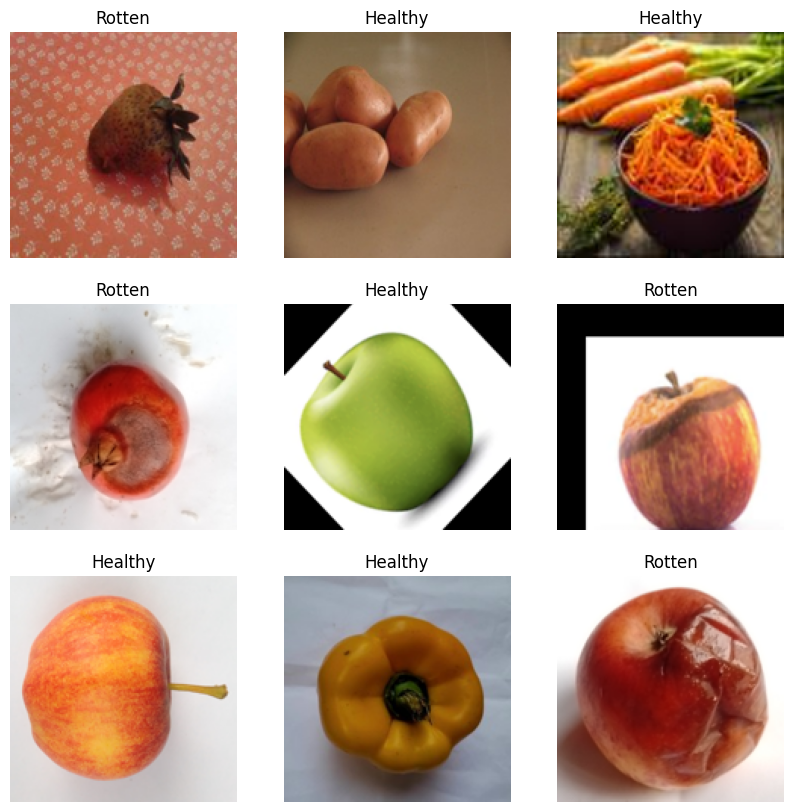

In [10]:
class_names = ["Healthy", "Rotten"]

# Quick visualization of training images
plt.figure(figsize=(10, 10))
for images, labels_b in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[int(labels_b[i])])
        plt.axis("off")
plt.show()

In [11]:
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
EPOCHS = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/5
170/481 ━━━━━━━━━━━━━━━━━━━━ 11:40 2s/step - accuracy: 0.6264 - loss: 0.7202

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


481/481 ━━━━━━━━━━━━━━━━━━━━ 1459s 3s/step - accuracy: 0.6833 - loss: 0.6145 - val_accuracy: 0.7846 - val_loss: 0.4332
Epoch 2/5
481/481 ━━━━━━━━━━━━━━━━━━━━ 1155s 2s/step - accuracy: 0.8182 - loss: 0.3951 - val_accuracy: 0.8633 - val_loss: 0.3208
Epoch 3/5
481/481 ━━━━━━━━━━━━━━━━━━━━ 1192s 2s/step - accuracy: 0.8754 - loss: 0.2973 - val_accuracy: 0.8971 - val_loss: 0.2577
Epoch 4/5
481/481 ━━━━━━━━━━━━━━━━━━━━ 1210s 2s/step - accuracy: 0.9067 - loss: 0.2334 - val_accuracy: 0.9059 - val_loss: 0.2400
Epoch 5/5
481/481 ━━━━━━━━━━━━━━━━━━━━ 1227s 2s/step - accuracy: 0.9342 - loss: 0.1724 - val_accuracy: 0.9166 - val_loss: 0.2122


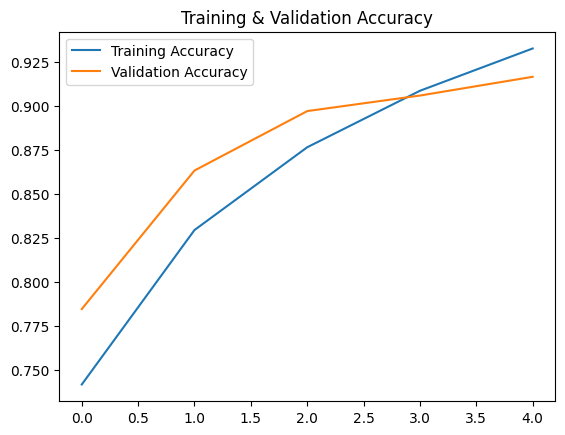

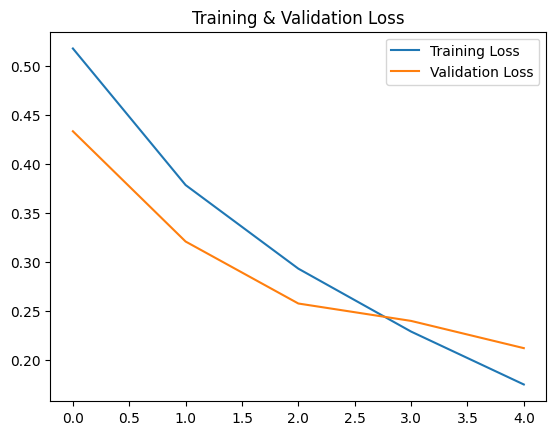

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure()
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()

plt.figure()
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

In [14]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

# Get predictions for confusion matrix and classification report
y_pred = []
y_true = []

for images, labels_b in test_ds:
    preds = model.predict(images)
    # Round sigmoid outputs -> 0 or 1
    preds_rounded = np.round(preds).astype(int).flatten()
    y_pred.extend(preds_rounded)
    y_true.extend(labels_b.numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

151/151 ━━━━━━━━━━━━━━━━━━━━ 484s 3s/step - accuracy: 0.9193 - loss: 0.2239
Test Accuracy: 0.9150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━

Confusion Matrix:
[[2048  204]
 [ 205 2353]]


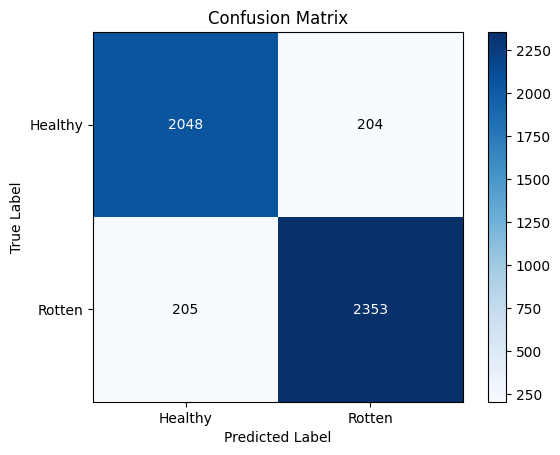

In [15]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure()
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], class_names)
plt.yticks([0,1], class_names)

# Write counts
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


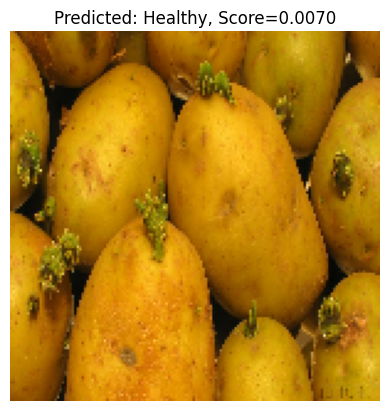

In [16]:
def predict_single_image(model, img_path):
    # Load & preprocess
    image_raw = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image_raw, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    # Expand batch dimension
    image_expanded = tf.expand_dims(image, 0)

    # Predict
    pred = model.predict(image_expanded)[0][0]
    # 0 -> Healthy, 1 -> Rotten
    label = class_names[int(round(pred))]

    # Show the image
    plt.figure()
    plt.imshow(image.numpy())
    plt.title(f"Predicted: {label}, Score={pred:.4f}")
    plt.axis("off")
    plt.show()


# Example usage:
sample_path = test_paths[0]  # Just pick a random test image
predict_single_image(model, sample_path)